In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from textblob import TextBlob
from collections import Counter
import spacy


In [ ]:

data = pd.read_csv("C:/Users/Anagha/Downloads/df_tweets_HiQualProp.csv", encoding='utf-8')

# Select relevant columns
data = data[['text_normalized', 'labels']]

# Rename the columns for clarity
data.columns = ['text', 'labels']

# Map labels to binary values
data['labels'] = data['labels']

# Verify the changes
print(data.head())
print(data.info())


                                                text  labels
0  I only see a country corrupted and economicall...       0
1  New to you that Pope is on the side of murder ...       0
2  BJP PROPAGANDA AGAINST DELHI GOVT EXPOSED Tota...       0
3  Senate Democrats threaten to subpoena Barr , S...       0
4  Analysis : Russia understands Trump 's utility...       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29596 entries, 0 to 29595
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29596 non-null  object
 1   labels  29596 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 462.6+ KB
None


In [3]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

# Load profanity dataset
profanity_df = pd.read_csv("C:/Users/Anagha/Downloads/profanity_en.csv", encoding='utf-8')

# Clean and extract the severity column and words to match
profanity_list = profanity_df[['canonical_form_1', 'severity_rating']].dropna()  # Drop missing values

# Create a dictionary for fast lookups
profanity_dict = dict(zip(profanity_list['canonical_form_1'], profanity_list['severity_rating']))

# Function to extract rhetorical features using N-grams
def extract_rhetorical_features(text, patterns, ngram_range=(1, 3)):
    features = {f'{key}_count': 0 for key in patterns.keys()}
    
    # Use CountVectorizer for n-gram extraction
    vectorizer = CountVectorizer(ngram_range=ngram_range, lowercase=True)
    ngrams = vectorizer.fit_transform([text]).toarray()
    ngram_list = vectorizer.get_feature_names_out()
    
    # Check if any rhetorical pattern is present in the n-grams
    for pattern, phrases in patterns.items():
        for phrase in phrases:
            if any(phrase.lower() in ngram for ngram in ngram_list):
                features[f'{pattern}_count'] += 1

    return features

# Function to extract features including profanity severity
def extract_features(text):
    features = {}
    
    # 1. Sentiment analysis for emotional strength
    sentiment = TextBlob(text).sentiment
    features['polarity'] = sentiment.polarity
    features['subjectivity'] = sentiment.subjectivity

    # 2. Profanity count and severity
    profane_words = [word for word in text.split() if word.lower() in profanity_dict]
    features['profanity_count'] = len(profane_words)
    
    # Calculate the total severity for found profanities
    features['profanity_severity'] = sum([profanity_dict[word.lower()] for word in profane_words]) / len(profane_words) if len(profane_words) > 0 else 0.0
    
    # 3. Text length metrics
    words = text.split()
    features['word_count'] = len(words)
    features['char_count'] = len(text)
    features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0

    # 4. Rhetorical device counts
    rhetorical_patterns = {
    # Emotional Appeals
    'appeal_to_emotion': [
        'fear', 'danger', 'vulnerable', 'threat', 'anger', 'injustice', 'hope', 'suffering', 
        'trauma', 'outrage', 'guilt', 'panic', 'revenge', 'shame', 'desperation', 'disaster', 
        'helpless', 'devastation', 'insecurity', 'emergency', 'torment', 'heartbreaking', 'grief', 
        'devastating', 'horror', 'dismay', 'dread', 'distress', 'horrific', 'sorrow', 'tormented'
    ],
    
    # Name Calling / Demonization
    'name_calling': [
        'traitor', 'liar', 'corrupt', 'enemy', 'coward', 'fraud', 'sell-out', 'manipulator', 
        'scum', 'puppet', 'thug', 'rat', 'hypocrite', 'criminal', 'snake', 'terrorist', 'villain', 
        'backstabber', 'deceiver', 'hater', 'parasite', 'oppressor', 'sellout', 'looter', 'scoundrel', 
        'fraudster', 'abuser', 'shameless', 'tyrant', 'cheat', 'enemy of the people', 'despicable'
    ],

    # Patriotism / Nationalism
    'appeal_to_nationalism': [
        'patriot', 'freedom', 'liberty', 'country', 'nation', 'protect', 'rights', 'homeland', 
        'defend', 'constitution', 'flag', 'justice', 'sacrifice', 'allegiance', 'loyalty', 
        'sovereignty', 'unity', 'pride', 'heritage', 'our people', 'revolution', 'founding fathers', 
        'united', 'national pride', 'duty', 'independence', 'honor', 'motherland', 'defense', 'sacred'
    ],

    # Exaggeration / Hyperbole
    'exaggeration': [
        'best', 'worst', 'always', 'never', 'unmatchable', 'unbeatable', 'revolutionary', 
        'ultimate', 'never-before-seen', 'one in a million', 'all-time', 'historical', 'unstoppable', 
        'immortal', 'most powerful', 'undefeated', 'the greatest', 'irreplaceable', 'unprecedented', 
        'insurmountable', 'unbelievable', 'overwhelming', 'unstoppable', 'miraculous', 'unfathomable', 
        'unrivaled', 'legendary', 'limitless', 'all-powerful', 'groundbreaking', 'world-changing'
    ],

    # Loaded Language / Stereotyping
    'loaded_language': [
        'radical', 'extremist', 'terrorist', 'dangerous', 'criminal', 'anarchist', 'sleeper cells', 
        'fanatic', 'subversive', 'threatening', 'insurgent', 'illegal', 'violent', 'horrific', 
        'brainwashed', 'unpatriotic', 'disruptive', 'violent', 'parasitic', 'unlawful', 'treacherous', 
        'seditious', 'unamerican', 'radicalized', 'subversive', 'malignant', 'corrosive', 'hostile', 
        'destructive', 'untrustworthy', 'tyrannical', 'dangerous ideology', 'radical thinking'
    ],

    # Slogans / Memes
    'slogans': [
        'make america great again', 'yes we can', 'hope', 'change', 'believe in us', 'unity', 
        'keep america great', 'we are the 99%', 'power to the people', 'we can do it', 'yes we will', 
        'the future is now', 'dare to dream', 'i have a dream', 'together we rise', 'it gets better', 
        'the best is yet to come', 'we shall overcome', 'rise above', 'forward together', 'change we can believe in',
        'hope for the future', 'not left, not right, forward', 'the peoples voice', 'break the chains'
    ],

    # Appeal to Authority
    'appeal_to_authority': [
        'experts say', 'studies show', 'science proves', 'trusted authority', 'according to the experts', 
        'research suggests', 'leading scholars', 'as seen in research', 'top scientists', 'according to data', 
        'authoritative sources', 'respected voices', 'science confirms', 'the facts speak for themselves',
        'world leaders agree', 'as proven by', 'trusted institutions', 'well-known experts', 'respected scholars',
        'peer-reviewed', 'experts in the field', 'trusted professionals', 'scientific consensus', 'documented evidence'
    ],

    # Bandwagon Fallacy
    'bandwagon': [
        'everyone is doing it', 'popular', 'consensus', 'join the movement', 'don’t be left out', 
        'all the cool kids are doing it', 'the majority agrees', 'follow the crowd', 'it’s trending', 
        'you’re missing out', 'everybody else', 'the latest craze', 'if you’re not with us, you’re against us',
        'everyone’s talking about it', 'this is the new normal', 'this is the future', 'this is the way', 
        'everyone’s jumping on board', 'the whole world is doing it', 'this is the popular choice'
    ],

    # False Dilemma
    'false_dilemma': [
        'us vs them', 'with us or against us', 'no middle ground', 'you’re either for us or against us', 
        'black and white', 'only two options', 'choose your side', 'either you’re with us or you’re the enemy', 
        'no compromise', 'either/or', 'you can’t have both', 'right or wrong', 'you’re either on the team or not',
        'make a decision', 'choose wisely', 'decide now', 'no turning back'
    ],

    # Red Herring
    'red_herring': [
        'distraction', 'irrelevant', 'focus on', 'don’t talk about', 'forget about', 'that’s not the issue', 
        'sidetracked', 'missed the point', 'what about...', 'let’s not talk about', 'focusing on the wrong thing', 
        'let’s move on', 'avoiding the real problem', 'don’t look over here', 'the real issue is', 'look over there'
    ]
    }

    # Add rhetorical pattern features
    features.update(extract_rhetorical_features(text, rhetorical_patterns))
    
    return features

# Apply the feature extraction
data = pd.read_csv("C:/Users/Anagha/Downloads/df_tweets_HiQualProp.csv", encoding='utf-8')  # Your dataset
feature_list = data['text'].apply(extract_features)
features_df = pd.DataFrame(list(feature_list))

# Combine features with labels
final_data = pd.concat([features_df, data['labels']], axis=1)

# Verify the final dataset
print(final_data.head())


   polarity  subjectivity  profanity_count  profanity_severity  word_count  \
0  -0.02500      0.637500                0                 0.0          19   
1  -0.08961      0.326299                0                 0.0          46   
2  -0.02500      0.462500                0                 0.0          41   
3  -0.40000      0.700000                0                 0.0          20   
4   0.00000      0.000000                0                 0.0          17   

   char_count  avg_word_length  appeal_to_emotion_count  name_calling_count  \
0         117         5.210526                        0                   2   
1         266         4.804348                        0                   1   
2         300         6.268293                        0                   0   
3         155         6.800000                        1                   1   
4         130         6.705882                        0                   0   

   appeal_to_nationalism_count  exaggeration_count  load

In [ ]:
from sklearn.model_selection import train_test_split

# Taking 20% of the entire dataset as a subset
subset_data = data.sample(frac=0.2, random_state=42)

# Splitting this subset into 80% training and 20% testing
X = subset_data.drop('labels', axis=1)  # Features (all columns except labels)
y = subset_data['labels']               # Target (labels column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes to confirm
print(f"Full dataset size: {data.shape}")
print(f"Subset size: {subset_data.shape}")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Full dataset size: (29596, 10)
Subset size: (5919, 10)
Training set size: (4735, 9)
Testing set size: (1184, 9)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')  
X_train_vec = tfidf_vectorizer.fit_transform(X_train['text'])
X_test_vec = tfidf_vectorizer.transform(X_test['text'])

# Training the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_vec)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       993
           1       0.74      0.18      0.29       191

    accuracy                           0.86      1184
   macro avg       0.80      0.59      0.61      1184
weighted avg       0.84      0.86      0.82      1184

Confusion Matrix:
 [[981  12]
 [156  35]]


In [ ]:
#Testing on remaining 80% of dataset 
remaining_data = data.drop(subset_data.index)  # Exclude the 20% subset
X_remaining = remaining_data.drop('labels', axis=1)  # Features
y_remaining = remaining_data['labels']              # Target

# Vectorize the remaining dataset
X_remaining_vec = tfidf_vectorizer.transform(X_remaining['text'])

# Predict and evaluate on the remaining dataset
y_remaining_pred = model.predict(X_remaining_vec)

# Print evaluation metrics
print("Evaluation on remaining 80% of the dataset:")
print("Classification Report:\n", classification_report(y_remaining, y_remaining_pred))
print("Confusion Matrix:\n", confusion_matrix(y_remaining, y_remaining_pred))


Evaluation on remaining 80% of the dataset:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93     20093
           1       0.72      0.18      0.29      3584

    accuracy                           0.87     23677
   macro avg       0.80      0.58      0.61     23677
weighted avg       0.85      0.87      0.83     23677

Confusion Matrix:
 [[19840   253]
 [ 2935   649]]


In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np


X = final_data.drop('labels', axis=1)  # Features
y = final_data['labels']  # Labels

# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X, y)

# Get the coefficients for each feature
coefficients = model.coef_[0]  # Get coefficients for the first class (propaganda)

# Create a DataFrame to display the features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Sort the features by absolute coefficient value to see the most important ones
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].apply(np.abs)
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance)


                        Feature  Coefficient  Abs_Coefficient
15          false_dilemma_count     0.551939         0.551939
14              bandwagon_count    -0.501730         0.501730
12                slogans_count    -0.475108         0.475108
1                  subjectivity    -0.319652         0.319652
2               profanity_count     0.310287         0.310287
13    appeal_to_authority_count    -0.259138         0.259138
7       appeal_to_emotion_count    -0.236247         0.236247
0                      polarity    -0.184548         0.184548
3            profanity_severity    -0.177150         0.177150
11        loaded_language_count    -0.117376         0.117376
8            name_calling_count     0.105667         0.105667
9   appeal_to_nationalism_count     0.087478         0.087478
10           exaggeration_count    -0.073278         0.073278
16            red_herring_count     0.024492         0.024492
4                    word_count     0.024363         0.024363
6       

C:\Users\Anagha\AppData\Local\Temp\ipykernel_17728\2634427224.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


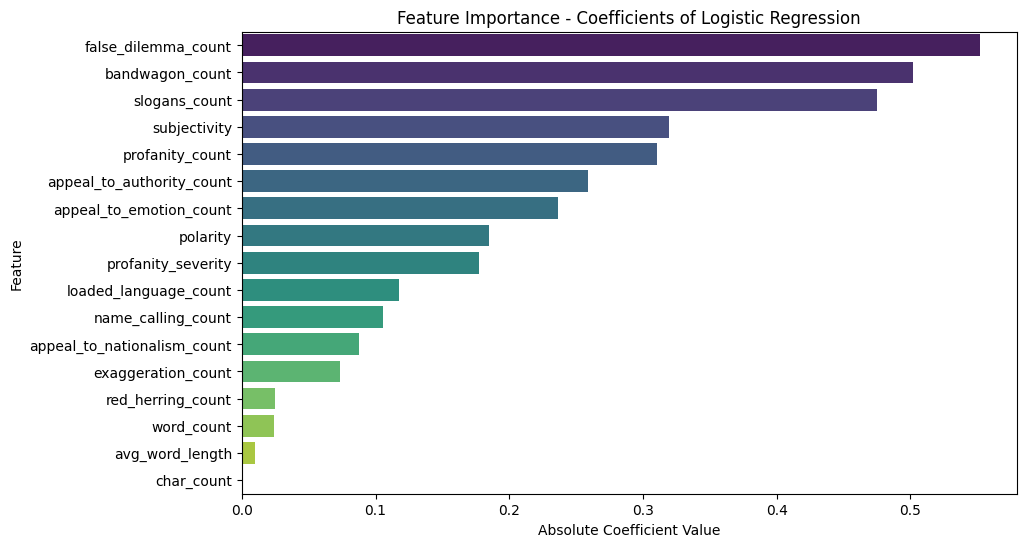

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with feature names and their absolute coefficients
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coefficients)  # Using absolute values for importance
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance - Coefficients of Logistic Regression")
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()
